# Libraries

In [ ]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
import statsmodels.api as sm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from termcolor import colored
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.svm import LinearSVC
from datetime import datetime
from scipy.stats import entropy
import os
import pickle
import trjtrypy as tt
from trjtrypy.distances import d_Q
from trjtrypy.distances import d_Q_pi
import trjtrypy.visualizations as vs
from scipy.spatial import distance
from trjtrypy.featureMappings import curve2vec

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler
import torchvision.transforms as T

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Read Data

In [ ]:
I = glob.glob('Geolife Trajectories 1.3/**/*.plt', recursive=True)
S = list(set([I[i][:45] for i in range(len(I))]))
user_idx = np.array([S[i][30:33] for i in range(len(S))])
print(user_idx[:10])
len(S), S[0]

['134' '085' '002' '045' '021' '081' '080' '054' '122' '043']


(182, 'Geolife Trajectories 1.3/Data/134/Trajectory/')

In [ ]:
def read_file(path):
    J = glob.glob(path, recursive=True)
    data = [0] * len(J)
    c = 0
    for j in range(len(J)):
        data[j] = []
        with open(J[j], "r") as f:
            for line in f:
                if c > 6:
                    item = line.strip().split(",")
                    if len(item) == 7:
                        data[j].append(np.array([float(item[0]), float(item[1]), 
                                                 float(item[4])]))
                c += 1
        data[j] = np.array(data[j])
    return np.array(data)

### data1[i] in the following is user_i from Beijing dataset 

trajectories have time dimension in data1

In [ ]:
start_time = time.time()
user_idx_int = np.array(list(map(int, user_idx)))
data1 = [0] * len(S)
for i in range(len(S)):
    idx = np.where(user_idx_int == i)[0][0]
    path = S[idx]+'*.plt'
    J = glob.glob(path, recursive=True)
    data1[i] = read_file(path)
data1 = np.array(data1)
print(time.time() - start_time)

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


118.77582788467407


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


In [ ]:
data_1 = data1 + 0
len(data_1)

182

In [ ]:
def remove_segments(traj): # removes stationary points
    p2 = traj[:,:2][1:]
    p1 = traj[:,:2][:-1]
    L = ((p2-p1)*(p2-p1)).sum(axis =1)
    I = np.where(L>1e-16)[0]
    return traj[I]

### In data_1 below:
    (1) there is no stationary points
    (2) there is no trajectories with more than 200 waypoints

In [ ]:
for i in range(len(data_1)):
    data_1[i] = np.array(list(map(remove_segments, data_1[i])), dtype='object')
    L = np.array([len(data_1[i][j]) for j in range(len(data_1[i]))])
    I = np.where((L > 1000))[0]
    data_1[i] = data_1[i][I]

I = np.where(np.array([len(data_1[i]) for i in range(len(data_1))]) > 0)[0]
data_1 = data_1[I]
print("len(data_1) =", len(data_1))
print("selected users: \n", I)

len(data_1) = 136
selected users: 
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  48  49  50  51  52  54  55  56
  58  59  62  63  64  65  66  67  68  69  70  71  73  74  75  77  78  81
  82  83  84  85  88  89  92  93  95  96 100 101 103 104 111 112 113 114
 115 116 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 135 137 140 141 142 143 144 145 147 148 149 151 152 153 155 156 158 159
 160 163 165 167 168 169 172 177 179 180]


# Partitioning trajectories to less than 20 minutes long

In [ ]:
def partition(trajectory, threshold=20):
    '''threshold is in minutes'''
    trajectories = []
    a = 24 * 60 * sum(trajectory[:,2][1:] - trajectory[:,2][:-1])
    if a <= threshold:
        return np.array(trajectory.reshape(1, len(trajectory), 3))
    else: 
        i = 0
        while a > threshold:
            j = i + 0
            val = 0
            while val < threshold: 
                if i < len(trajectory) - 1:
                    temp = val + 0
                    val += 24 * 60 * (trajectory[:,2][1:][i] - trajectory[:,2][:-1][i])
                    i += 1
                else: 
                    break
            if len(trajectory[j:i-1]) > 0:
                trajectories.append(trajectory[j:i-1])
            a = a - val
        if len(trajectory[i:]) > 0:
            trajectories.append(trajectory[i:])
    return np.array(trajectories)

In [ ]:
# 24 * 60 * (days_date('1899/12/30 2:50:06') - days_date('1899/12/30 2:20:06')) == 20 min
Time = [0] * len(data_1)
for i in range(len(data_1)):
    Time[i] = []
    for j in range(len(data_1[i])):
        Time[i].append(24 * 60 * sum(data_1[i][j][:,2][1:] - data_1[i][j][:,2][:-1])) # = 20 minutes 
    Time[i] = np.array(Time[i], dtype='object')

Time = np.array(Time, dtype='object')
Time.shape

(136,)

In [ ]:
J = [np.where(Time[i] > 20)[0] for i in range(len(Time))]
print(len(J))

136


### data3 below is the array of trajectories having less than 20 minutes long

In [ ]:
data3 = [0] * len(data_1)

for i in range(len(data_1)):
    data3[i] = []
    for j in range(len(data_1[i])):
        A = partition(data_1[i][j], threshold=20)
        for k in range(len(A)):
            data3[i].append(A[k])
    data3[i] = np.array(data3[i], dtype='object')
    
data3 = np.array(data3, dtype='object')

data3.shape, data3[0].shape, data3[0][0].shape

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


((136,), (812,), (116, 3))

In [ ]:
A = [len(data_1[0][i]) for i in range(len(data_1[0]))]
print(A)

[1696, 1777, 1894, 1681, 1132, 1332, 2167, 1490, 1838, 3141, 1399, 2174, 1091, 1644, 1585, 2843, 2153, 1837, 2138, 3013, 2727, 3753, 3442, 1221, 2322, 1219, 1326, 5348, 3425, 1272, 1421, 1530, 1351, 1036, 12912, 3114, 2350, 1655, 1916, 1771, 2276, 2011, 1158, 1714, 1948, 2144, 3472, 1043, 1315, 5390, 1038, 4501, 1061, 3448, 1422]


In [ ]:
data4 = data3 + 0

data4 is the users having between 100 and 200 trajectories and each has length between 10 and 200 trajectory

In [ ]:
for i in range(len(data4)):
    A = np.array([len(data4[i][j]) for j in range(len(data4[i]))])
    I = np.where((A > 10) & (A < 200))[0]
    data4[i] = data4[i][I]
    
print(len(data4))
A = np.array([len(data4[i]) for i in range(len(data4))])
chosen_users = np.where((A > 100) & (A < 200))[0]
data4 = data4[chosen_users]

print("chosen users:", chosen_users)
print("len(data4) =", len(data4))
A = [len(data4[i]) for i in range(len(data4))]
print("length of preprocessed users in data4: \n", np.sort(A))

136
chosen users: [  1   9  12  13  15  16  18  25  32  33  39  42  43  48  59  65  99 112
 125 130]
len(data4) = 20
length of preprocessed users in data4: 
 [108 112 113 117 120 121 122 132 140 151 152 154 159 163 171 174 177 181
 193 197]


### data2 is the same as data4 but without time dimension

In [ ]:
data2 = data4 + 0
for i in range(len(data2)):
    data2[i] = np.array([data4[i][j][:,:2] for j in range(len(data4[i]))], dtype='object')
len(data2)

20

In [ ]:
np.sort(list(map(len, data2)))

array([108, 112, 113, 117, 120, 121, 122, 132, 140, 151, 152, 154, 159,
       163, 171, 174, 177, 181, 193, 197])

# Classifiers

In [ ]:
CC = [100, 100, 10]
number_estimators = [50, 50]


clf0 = [make_pipeline(LinearSVC(dual=False, C=CC[0], tol=1e-5, 
                               class_weight ='balanced', max_iter=1000)), 
        "SVM, LinearSVC, C = "+str(CC[0])]
clf1 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[1], kernel='rbf', gamma='auto', max_iter=200000)),
        "Gaussian SVM, C="+str(CC[1])+", gamma=auto"]
clf2 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[2], kernel='poly', degree=3, max_iter=400000)),
        "Poly kernel SVM, C="+str(CC[2])+", deg=auto"]
clf3 = [DecisionTreeClassifier(), "Decision Tree"]
clf4 = [RandomForestClassifier(n_estimators=number_estimators[0]), 
         "RandomForestClassifier, n="+str(number_estimators[0])]
clf5 = [KNeighborsClassifier(n_neighbors=5), "KNN"]
clf6 = [LogisticRegression(solver='newton-cg'), "Logistic Regression"]

clf = [clf0, clf1, clf2, clf3, clf4, clf5, clf6]
classifs = [item[0] for item in clf]
keys = [item[1] for item in clf]

# Chosen pairs of users

In [ ]:
pairs_final = [[4, 12], [4, 16], [5, 12], [8, 10]]
pairs_final

[[4, 12], [4, 16], [5, 12], [8, 10]]

# Plot data

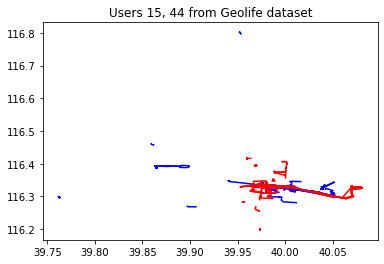

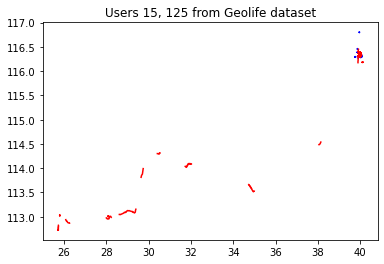

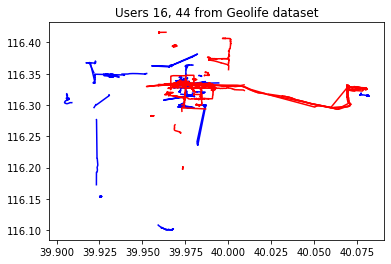

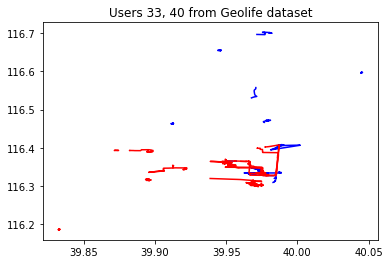

In [ ]:
data = data2.copy()
pairs_from_data = [(15, 44), (15, 125), (16, 44), (33, 40)]
path = '/Users/hasan/Desktop/Anaconda/Research/Pictures for 2ed paper/'
for k in range(len(pairs_final)):
    m, n = pairs_final[k]
    r, s = pairs_from_data[k]
    for i in range(len(data[m])):
        plt.plot(data[m][i][:,0], data[m][i][:,1], color='blue')
    for i in range(len(data[n])):
        plt.plot(data[n][i][:,0], data[n][i][:,1], color='red')
    plt.title(f'Users {r}, {s} from Geolife dataset')
    plt.savefig(path+f'Beijing-pairs {pairs_from_data[k]}.png', bbox_inches='tight', 
                dpi=200)
    plt.show()

# Get length and width of the box containig pairs

In [ ]:
for k in range(len(pairs_final)):
    m, n = pairs_final[k]
    r, s = pairs_from_data[k]
    min_x, min_y = np.min((np.min([np.min(data[m][i], axis=0) for i in range(len(data[m]))], axis=0), 
           np.min([np.min(data[n][i], axis=0) for i in range(len(data[n]))], axis=0)), axis=0)

    max_x, max_y = np.max((np.max([np.max(data[m][i], axis=0) for i in range(len(data[m]))], axis=0), 
                   np.max([np.max(data[n][i], axis=0) for i in range(len(data[n]))], axis=0)), axis=0)

    print(f"length and width of pair {r, s}:", np.round(max_x - min_x, decimals=2), 
          np.round(max_y - min_y, decimals=2))
    print("len(data[m]), len(data[n]):", len(data[m]), len(data[n]))
    print()

length and width of pair (15, 44): 0.32 0.6
len(data[m]), len(data[n]): 154 197

length and width of pair (15, 125): 14.37 4.07
len(data[m]), len(data[n]): 154 122

length and width of pair (16, 44): 0.18 0.32
len(data[m]), len(data[n]): 140 197

length and width of pair (33, 40): 0.21 0.52
len(data[m]), len(data[n]): 117 193



In [ ]:
print('average test error for 4 pairs:', list(np.round(list(np.mean(test_errors_ave, 0)), decimals=4)))
print()
print('average std error for 4 pairs: ', list(np.round(list(np.mean(std_errors_ave, 0)), decimals=4)))
print()

#average test error for 4 pairs: [0.2888, 0.2447, 0.2567, 0.2132, 0.1731, 0.2067, 0.3022]

#average std error for 4 pairs:  [0.0448, 0.0364, 0.0397, 0.039, 0.0338, 0.0395, 0.0359]

# KNN classification with 10 distances:
    discret_frechet, hausdorff, dtw, sspd, erp, edr, lcss, fastdtw, dtw_tslearn, d_Q_pi

In [ ]:
from KNN_Class import KNN

In [ ]:
import numpy as np
import time
import pandas as pd
import random
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import traj_dist.distance as tdist
import pickle
import tslearn
from tslearn.metrics import dtw as dtw_tslearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from trjtrypy.distances import d_Q_pi
from termcolor import colored
from sdtw import SoftDTW

metrics = ['discret_frechet', 'hausdorff', dtw_tslearn, SoftDTW, fastdtw, 'lcss', 'sspd',
           'edr', 'erp', 'd_Q_pi']

path = 'Calculated Distance Matrices for KNN-T-drive/'

train_test_mean_median_std_KNN_errors = []
test_KNN_errors = []
std_KNN_errors = []

for pair in pairs_final:
    print('pair =', pair)
    temp = []
    for i in range(len(metrics)):
        KNN_class = KNN(data[pair[0]], data[pair[1]], metric=metrics[i], gamma=1e-15, 
                        eps_edr=0.001, eps_lcss=0.001, Q_size=20, Q=None, p=2, 
                        path=path+str(metrics[i])+'-'+str(pair), 
                        test_size=0.3, n_neighbors=5, num_trials=50, pair=[0,1])

        KNN_class.write_matrix_to_csv()
        A = KNN_class.KNN_average_error()
        temp.append(A[1:])        
        print(i, A[0])
        print("==========================================================================")
    
    train_test_mean_median_std_KNN_errors.append(temp)
    test_KNN_errors.append(np.array(temp)[:,1])
    std_KNN_errors.append(np.array(temp)[:,3])
    print(colored("******************************************************************************", 'red'))
    print(colored("******************************************************************************", 'red'))
    print(colored("******************************************************************************", 'red'))
    
train_test_mean_median_std_KNN_errors = np.array(train_test_mean_median_std_KNN_errors)
test_KNN_errors = np.array(test_KNN_errors)
std_KNN_errors = np.array(std_KNN_errors)

list_test_error = list(np.round(np.mean(test_KNN_errors, 0), decimals=4))
list_std_error = list(np.round(np.mean(std_KNN_errors, 0), decimals=4))
print(colored(f'average test errors of 4 pairs: \n {list_test_error}', 'magenta'))
print(colored(f'average stds of 4 pairs: \n {list_std_error}', 'yellow'))


pair = [4, 12]
num_trials = 50
total time = 2.317761182785034
0                           Classifier  Train Error    Mean  Median     Std
1  KNN; discret_frechet; pair [0, 1]       0.1403  0.2086   0.215  0.0285
num_trials = 50
total time = 2.2159080505371094
1                     Classifier  Train Error    Mean  Median    Std
1  KNN; hausdorff; pair [0, 1]       0.1411  0.2028  0.2056  0.035
num_trials = 50
total time = 2.271644115447998
2                                           Classifier  Train Error    Mean  \
1  KNN; <function dtw at 0x7fb315cd7c20>; pair [0...       0.1274  0.1966   

   Median     Std  
1  0.1963  0.0348  
num_trials = 50
total time = 2.2925539016723633
3                                           Classifier  Train Error    Mean  \
1  KNN; <class 'sdtw.soft_dtw.SoftDTW'>; pair [0, 1]       0.1254  0.2088   

   Median     Std  
1  0.2056  0.0308  
num_trials = 50
total time = 2.28794002532959
4                                       Classifier  Train Error    Me

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/traj_dist-1.1-py3.7-macosx-10.9-x86_64.egg/traj_dist/distance.py:552: UserWarning: g parameter should be specified for metric erp. Default is 
  warnings.warn("g parameter should be specified for metric erp. Default is ")


num_trials = 50
total time = 2.278203010559082
8               Classifier  Train Error    Mean  Median     Std
1  KNN; erp; pair [0, 1]       0.2843  0.4497  0.4486  0.0473
num_trials = 50
total time = 2.240666151046753
9                  Classifier  Train Error    Mean  Median     Std
1  KNN; d_Q_pi; pair [0, 1]       0.1484  0.2125   0.215  0.0334
******************************************************************************
******************************************************************************
******************************************************************************
pair = [4, 16]
num_trials = 50
total time = 1.5940639972686768
0                           Classifier  Train Error    Mean  Median     Std
1  KNN; discret_frechet; pair [0, 1]       0.1351  0.1812  0.1786  0.0411
num_trials = 50
total time = 1.7579379081726074
1                     Classifier  Train Error    Mean  Median     Std
1  KNN; hausdorff; pair [0, 1]       0.1211  0.1755  0.1786  0.0404
num_trials =

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/traj_dist-1.1-py3.7-macosx-10.9-x86_64.egg/traj_dist/distance.py:552: UserWarning: g parameter should be specified for metric erp. Default is 
  warnings.warn("g parameter should be specified for metric erp. Default is ")


num_trials = 50
total time = 1.9995391368865967
8               Classifier  Train Error    Mean  Median     Std
1  KNN; erp; pair [0, 1]       0.2543  0.3874   0.381  0.0431
num_trials = 50
total time = 1.7985057830810547
9                  Classifier  Train Error    Mean  Median     Std
1  KNN; d_Q_pi; pair [0, 1]       0.1187  0.1693  0.1667  0.0359
******************************************************************************
******************************************************************************
******************************************************************************
pair = [5, 12]
num_trials = 50
total time = 2.4966306686401367
0                           Classifier  Train Error    Mean  Median     Std
1  KNN; discret_frechet; pair [0, 1]       0.1649  0.2296  0.2304  0.0404
num_trials = 50
total time = 2.400822639465332
1                     Classifier  Train Error    Mean  Median     Std
1  KNN; hausdorff; pair [0, 1]       0.1465  0.2035  0.1961  0.0361
num_trials 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/traj_dist-1.1-py3.7-macosx-10.9-x86_64.egg/traj_dist/distance.py:552: UserWarning: g parameter should be specified for metric erp. Default is 
  warnings.warn("g parameter should be specified for metric erp. Default is ")


num_trials = 50
total time = 2.3560709953308105
8               Classifier  Train Error    Mean  Median     Std
1  KNN; erp; pair [0, 1]       0.2917  0.4533  0.4559  0.0393
num_trials = 50
total time = 2.2860872745513916
9                  Classifier  Train Error    Mean  Median     Std
1  KNN; d_Q_pi; pair [0, 1]       0.1429  0.2333  0.2353  0.0353
******************************************************************************
******************************************************************************
******************************************************************************
pair = [8, 10]
num_trials = 50
total time = 1.8766758441925049
0                           Classifier  Train Error    Mean  Median     Std
1  KNN; discret_frechet; pair [0, 1]       0.1427  0.2251  0.2287  0.0401
num_trials = 50
total time = 2.0559158325195312
1                     Classifier  Train Error    Mean  Median     Std
1  KNN; hausdorff; pair [0, 1]       0.1431  0.2121  0.2128  0.0395
num_trials

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/traj_dist-1.1-py3.7-macosx-10.9-x86_64.egg/traj_dist/distance.py:552: UserWarning: g parameter should be specified for metric erp. Default is 
  warnings.warn("g parameter should be specified for metric erp. Default is ")


num_trials = 50
total time = 1.9347190856933594
8               Classifier  Train Error    Mean  Median     Std
1  KNN; erp; pair [0, 1]       0.3059  0.4749  0.4787  0.0391
num_trials = 50
total time = 1.9022138118743896
9                  Classifier  Train Error    Mean  Median     Std
1  KNN; d_Q_pi; pair [0, 1]       0.1394  0.2053  0.2021  0.0361
******************************************************************************
******************************************************************************
******************************************************************************
average test errors of 4 pairs: 
 [0.2111, 0.1985, 0.1921, 0.1946, 0.194, 0.2138, 0.1717, 0.3315, 0.4413, 0.2051]
average stds of 4 pairs: 
 [0.0375, 0.0377, 0.0357, 0.0368, 0.0346, 0.0468, 0.0383, 0.0464, 0.0422, 0.0352]


## KNN with LSH

In [ ]:
from KNN_with_LSH_class import KNN_with_LSH

In [ ]:
train_test_mean_median_std_KNN_LSH_errors = []
test_KNN_LSH_errors = []
std_KNN_LSH_errors = []
i = 0
for pair in pairs_final:
    st = time.time()
    print('pair =', pair)
    KNN_with_LSH_class = KNN_with_LSH(data[pair[0]], data[pair[1]], number_circles=20, 
                                      num_trials=50)
    A = KNN_with_LSH_class.KNN_LSH_average_error()
    train_test_mean_median_std_KNN_LSH_errors.append(A[1:])        
    print(i, A[0])
    i += 1
    print(colored(f"total time for pair {i}: {time.time()-st}", 'red'))
    print("=======================================================================")
    
train_test_mean_median_std_KNN_LSH_errors = np.array(train_test_mean_median_std_KNN_LSH_errors)
test_KNN_LSH_errors = train_test_mean_median_std_KNN_LSH_errors[:,1]
std_KNN_LSH_errors = train_test_mean_median_std_KNN_LSH_errors[:,3]

print(np.mean(test_KNN_LSH_errors))

test_error = np.round(np.mean(test_KNN_LSH_errors, 0), decimals=4)
std_error = np.round(np.mean(std_KNN_LSH_errors, 0), decimals=4)
print(colored(f'average test error for 4 pairs: {test_error}', 'magenta'))
print(colored(f'average stds of 4 pairs:        {std_error}', 'yellow'))

#path = 'Claculated test errors for correlation/Beijing/KNN_LSH_test_errors_Beijing.csv'
#np.savetxt(path, test_KNN_LSH_errors, delimiter=',')

#path = 'Claculated test errors for correlation/Beijing/train_test_mean_median_std_KNN_LSH_errors.csv'
#np.savetxt(path, train_test_mean_median_std_KNN_LSH_errors, delimiter=',')


pair = [4, 12]
num_trials = 50
total time = 8.83545708656311
0      Classifier  Train Error  Test Error     std
1  KNN with LSH       0.3326      0.3703  0.0656
total time for pair 1: 8.838053703308105
pair = [4, 16]
num_trials = 50
total time = 7.406907081604004
1      Classifier  Train Error  Test Error     std
1  KNN with LSH       0.3941      0.3938  0.0801
total time for pair 2: 7.410536289215088
pair = [5, 12]
num_trials = 50
total time = 8.800378322601318
2      Classifier  Train Error  Test Error     std
1  KNN with LSH       0.3707      0.3871  0.0651
total time for pair 3: 8.802664995193481
pair = [8, 10]
num_trials = 50
total time = 7.9377830028533936
3      Classifier  Train Error  Test Error     std
1  KNN with LSH       0.3113      0.3083  0.1369
total time for pair 4: 7.939993858337402
0.3648616483777842
average test error for 4 pairs: 0.3649
average stds of 4 pairs:        0.0869


# Classification with Perceptron-Like Algorithm

## Import Class

In [ ]:
from Perceptron_Like_Algo_Class import classification

## Vote(MD $v_Q^{\exp}$) with epoch=50, majority=11 and init_num=3

In [ ]:
m, n = pairs_final[0]

for Model in ['LSVM', 'GSVM', 'PSVM']:
    classif = classification(data[m], data[n], Q_size=20, model=Model, C=10, gamma=10, 
                         classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")
    time.sleep(600)

total time = 2952.0269157886505
              Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=10       0.2144      0.2693     0.0571
mu = 0.007590478403507461
total time = 3193.5884668827057
             Classifier  Train Error  Test Error  Std Error
1  GSVM, C=10, gamma=10       0.0001      0.2422     0.0331
mu = 0.005045800527469169


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 2885.0669219493866
                        Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=10, deg=auto       0.1589      0.2626     0.0319
mu = 0.001188832447773791


NameError: name 'probs' is not defined

In [ ]:
m, n = pairs_final[0]

for Model in ['DT', 'RF', 'KNN', 'LR']:
    classif = classification(data[m], data[n], Q_size=20, model=Model, C=10, gamma=10, 
                         classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")
    time.sleep(300)

total time = 2759.6081590652466
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.2028     0.0367
mu = 0.007619498582911888
total time = 4668.555550336838
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0151      0.1807     0.0316
mu = 0.01123278171052533
total time = 2657.001133918762
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1334      0.2101     0.0325
mu = 0.009165917708727989
total time = 2389.428100824356
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.2831      0.3144     0.0536
mu = 0.00651783535134598


In [ ]:
m, n = pairs_final[1]

for Model in ['LSVM', 'GSVM', 'PSVM', 'DT']:
    classif = classification(data[m], data[n], Q_size=20, model=Model, C=100, gamma=10, 
                         classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")
    time.sleep(300)

total time = 2310.322911977768
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.3106      0.3326     0.0598
mu = 1.9257498132118442
total time = 2338.956046819687
              Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=10       0.0512      0.1502     0.0447
mu = 2.096489820791554


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 2296.2201647758484
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.3096      0.3212     0.0511
mu = 2.289320977860818
total time = 2160.038941860199
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.1433     0.0317
mu = 2.13698718325157


In [ ]:
m, n = pairs_final[1]

for Model in ['RF', 'KNN', 'LR']:
    classif = classification(data[m], data[n], Q_size=20, model=Model, C=100, gamma=10, 
                         classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")
    time.sleep(300)

total time = 3899.3125879764557
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.1279     0.0334
mu = 2.4710049799464144
total time = 2183.9453160762787
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.0999      0.1526     0.0366
mu = 1.7430121103926908
total time = 2216.678565979004
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.3541      0.3579     0.0257
mu = 2.1022594963955967


In [ ]:
m, n = pairs_final[2]

for Model in ['LSVM', 'GSVM', 'PSVM', 'DT']:
    classif = classification(data[m], data[n], Q_size=20, model=Model, C=100, gamma=10, 
                         classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")
    time.sleep(300)

total time = 2260.4392988681793
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.1931      0.2329     0.0449
mu = 0.04931888851675126
total time = 2517.4284999370575
              Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=10       0.0028      0.2218     0.0355
mu = 0.04248502301763324


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 2474.7631208896637
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.1517      0.2116     0.0248
mu = 0.042925153484389966
total time = 2227.538239002228
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.1794     0.0314
mu = 0.05186750841301091


In [ ]:
m, n = pairs_final[2]

for Model in ['RF', 'KNN', 'LR']:
    classif = classification(data[m], data[n], Q_size=20, model=Model, C=100, gamma=10, 
                         classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")
    time.sleep(300)

total time = 4138.066447734833
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.1614      0.036
mu = 0.0415861977217844
total time = 2472.0089530944824
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1176      0.1902     0.0327
mu = 0.04940614089370854
total time = 2257.1296541690826
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.2809      0.2967     0.0461
mu = 0.03903796347916


In [ ]:
m, n = pairs_final[3]

for Model in ['LSVM', 'GSVM', 'PSVM', 'DT']:
    classif = classification(data[m], data[n], Q_size=20, model=Model, C=100, gamma='auto', 
                         classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")
    time.sleep(300)

total time = 2183.720324754715
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.2396      0.2611     0.0369
mu = 0.13041165644007435
total time = 2472.9986560344696
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto       0.1929      0.2219     0.0359
mu = 0.129003274362276


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 2514.0722641944885
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.2001      0.2117     0.0348
mu = 0.11487392991416812
total time = 2494.3698477745056
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.2087     0.0359
mu = 0.13251041457438362


In [ ]:
m, n = pairs_final[3]

for Model in ['RF', 'KNN', 'LR']:
    classif = classification(data[m], data[n], Q_size=20, model=Model, C=100, gamma='auto',
                         classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")
    time.sleep(300)

total time = 4721.830580949783
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.1909     0.0327
mu = 0.12850937312941824
total time = 2916.3874051570892
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1269      0.2196       0.04
mu = 0.12764478679443414
total time = 2625.2792630195618
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.2178      0.2128     0.0279
mu = 0.11736654753569553


In [ ]:
# average errors of 5 pairs reported in the paper (epoch=100, maj=1, init_iter=3)
print('LSVM:', np.round((0.2693 +0.3326 +0.2329 +0.2611 )/4, decimals=4), 
      np.round((0.0571 +0.0598 +0.0449 +0.0369 )/4, decimals=4))
print('GSVM:', np.round((0.2422 +0.1502 +0.2218 +0.2219 )/4, decimals=4), 
      np.round((0.0331 +0.0447 +0.0355 + 0.0359)/4, decimals=4))
print('PSVM:', np.round((0.2626 +0.3212 +0.2116 +0.2117 )/4, decimals=4), 
      np.round((0.0319 +0.0511 +0.0248 +0.0348 )/4, decimals=4))
print('DT:', np.round((0.2028 +0.1433 +0.1794 +0.2087 )/4, decimals=4), 
      np.round((0.0367 +0.0317 +0.0314 +0.0359 )/4, decimals=4))
print('RF:', np.round((0.1807 +0.1279 +0.1614 +0.1909 )/4, decimals=4),
      np.round((0.0316 +0.0334 +0.036 +0.0327 )/4, decimals=4))
print('KNN:', np.round((0.2101 +0.1526 +0.1902 +0.2196 )/4, decimals=4), 
      np.round((0.0325 +0.0366 +0.0327 +0.04 )/4, decimals=4))
print('LR:', np.round((0.3144 +0.3579 +0.2967 +0.2128 )/4, decimals=4),
      np.round((0.0536 +0.0257 +0.0461 +0.0279 )/4, decimals=4))

#LSVM: 0.274, 0.0497
#GSVM: 0.209, 0.0373
#PSVM: 0.2518, 0.0356
#DT: 0.1836, 0.0339
#RF: 0.1652, 0.0334
#KNN: 0.1931, 0.0354
#LR: 0.2954, 0.0383

LSVM: 0.274 0.0497
GSVM: 0.209 0.0373
PSVM: 0.2518 0.0356
DT: 0.1836 0.0339
RF: 0.1652 0.0334
KNN: 0.1931 0.0354
LR: 0.2954 0.0383


## MD $v_Q^{\exp}$ with epoch=50, majority=1 and init_num=3

In [ ]:
test_errors_ave = []
std_errors_ave = []

for pair in pairs_final: 
    m, n = pair
    print(f"pair: {m, n}")
    
    test_errors_temp = []
    std_errors_temp = []

    for Model in ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR']:
        classif = classification(data[m], data[n], Q_size=20, model=Model, C=100, 
                        gamma='auto', classifiers=[], epoch=50, maj_num=1, init_iter=3, 
                        std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

        A = classif.classification_Q()
        print(A[0])
        print(colored(f"mu = {A[1]}", 'blue'))
        test_errors_temp.append(np.array(A[0])[0][2])
        std_errors_temp.append(np.array(A[0])[0][3])
        print(colored('=======================================================================', 'yellow'))
    time.sleep(120)
    print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
    test_errors_ave.append(test_errors_temp)
    std_errors_ave.append(std_errors_temp)
    print(colored(f'test errors:     {test_errors_temp}', 'magenta'))
    print(colored(f'std test errors: {std_errors_temp}', 'green'))

print(colored('************************************************************************', 'red'))
print(colored('************************************************************************', 'red'))
print(colored('************************************************************************', 'red'))

# average errors of 5 pairs reported in the paper (epoch=50, maj=1, init_iter=3)

test_errors_ave = np.array(test_errors_ave)
std_errors_ave = np.array(std_errors_ave)

print('average test error for 4 pairs:', list(np.round(list(np.mean(test_errors_ave, 0)), decimals=4)))
print()
print('average std error for 4 pairs: ', list(np.round(list(np.mean(std_errors_ave, 0)), decimals=4)))
print()

pair: (4, 12)
total time = 259.4987277984619
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.2566      0.3036     0.0532
mu = 0.006028636549572752
total time = 287.60785722732544
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto       0.1429      0.2673     0.0519
mu = 0.009948380574250848


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 295.6810898780823
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.1325      0.2753     0.0503
mu = 0.007019161811612662
total time = 257.8913378715515
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.2383     0.0384
mu = 0.011131359992099021
total time = 472.55168199539185
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0172      0.2086     0.0373
mu = 0.01228222226762199
total time = 273.98957085609436
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1516      0.2372     0.0462
mu = 0.008319820907857434
total time = 259.216078042984
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.3052      0.3342     0.0479
mu = 0.004270405757182516
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
test errors:     [0.3036, 0.2673, 0.2753

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 212.65058016777039
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.3059      0.3188     0.0458
mu = 1.9633529605794564
total time = 204.77551794052124
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0        0.16     0.0377
mu = 1.9671960043297148
total time = 361.807021856308
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0002      0.1231     0.0344
mu = 2.0243973225601906
total time = 189.77271008491516
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1042      0.1621      0.036
mu = 2.350435418112909
total time = 211.7556071281433
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.3561      0.3526     0.0253
mu = 2.3442338180037154
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
test errors:     [0.3338, 0.2645, 0.3188, 0.16, 0

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 248.27287697792053
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.1531      0.2214     0.0372
mu = 0.03703233261522598
total time = 206.5126450061798
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.2159     0.0419
mu = 0.043130134174688806
total time = 385.89226174354553
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0005      0.1612     0.0361
mu = 0.04485251232077303
total time = 228.93536901474
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1248      0.2055     0.0421
mu = 0.04549012188454071
total time = 212.44553399085999
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.2824      0.3008     0.0445
mu = 0.03914037189962016
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
test errors:     [0.2533, 0.2239, 0.2214, 0

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 218.66407918930054
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.2008      0.2113     0.0254
mu = 0.11718471946782927
total time = 203.75111174583435
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.2385     0.0379
mu = 0.12925707799786323
total time = 381.09231209754944
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0006      0.1996     0.0272
mu = 0.13787374723845858
total time = 227.57509207725525
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1359      0.2219     0.0338
mu = 0.12651494666620522
total time = 210.4027600288391
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.2155      0.2213      0.026
mu = 0.13465701264688335
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
test errors:     [0.2643, 0.223, 0.2113, 

# Classification with feature mappings $v_Q$, $v_Q^{\exp}$, $v_Q^{\varsigma}$ with 20 random landmarks, and endpoints

In [ ]:
from v_Q_mu_endpoints_classification import binaryClassificationAverageMajority

## Classification with $v_Q$ with random $Q$ in each iteration

In [ ]:
# Voting v_Q
v_Q_maj_errors = []
v_Q_maj_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=50, num_trials_maj=11, classifiers=clf, 
                                            version='unsigned', test_size=0.3)
    A = classif.classification_v_Q()
    print(A[0])
    v_Q_maj_errors.append(np.round(A[2], decimals=4).tolist())
    v_Q_maj_stds.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_maj_errors = \n', v_Q_maj_errors)
print('v_Q_maj_stds = \n', v_Q_maj_stds)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(v_Q_maj_errors, 0), decimals=4))}', 'blue'))
print(colored(f'average stds:   {list(np.round(np.mean(v_Q_maj_stds, 0), decimals=4))}', 'green'))


pair=[4, 12]
total time = 128.28461909294128
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3384      0.3585     0.0546
2  Gaussian SVM, C=100, gamma=auto       0.2167      0.2660     0.0470
3  Poly kernel SVM, C=10, deg=auto       0.3666      0.3826     0.0416
4                    Decision Tree       0.0000      0.1951     0.0463
5     RandomForestClassifier, n=50       0.0000      0.1933     0.0350
6                              KNN       0.1455      0.2082     0.0388
7              Logistic Regression       0.4313      0.4376     0.0036
pair=[4, 16]
total time = 109.08738303184509
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3503      0.3664     0.0410
2  Gaussian SVM, C=100, gamma=auto       0.3569      0.3564     0.0271
3  Poly kernel SVM, C=10, deg=auto       0.3597      0.3564     0.0271
4                    Decision Tree       0.0000      0.247

In [ ]:
# Averaging v_Q
v_Q_errors = []
v_Q_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=50, num_trials_maj=1, classifiers=clf, 
                                            version='unsigned', test_size=0.3)
    A = classif.classification_v_Q()
    print(A[0])
    v_Q_errors.append(np.round(A[2], decimals=4).tolist())
    v_Q_stds.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_errors = \n', v_Q_errors)
print('v_Q_stds = \n', v_Q_stds)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(v_Q_errors, 0), decimals=4))}', 'blue'))
print(colored(f'average stds:   {list(np.round(np.mean(v_Q_stds, 0), decimals=4))}', 'green'))


pair=[4, 12]
total time = 15.66426968574524
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3502      0.3824     0.0548
2  Gaussian SVM, C=100, gamma=auto       0.2238      0.2613     0.0447
3  Poly kernel SVM, C=10, deg=auto       0.3687      0.3815     0.0520
4                    Decision Tree       0.0000      0.2361     0.0381
5     RandomForestClassifier, n=50       0.0004      0.1948     0.0386
6                              KNN       0.1498      0.2206     0.0337
7              Logistic Regression       0.4313      0.4374     0.0053
pair=[4, 16]
total time = 12.782309770584106
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3449      0.3476     0.0429
2  Gaussian SVM, C=100, gamma=auto       0.3586      0.3507     0.0284
3  Poly kernel SVM, C=10, deg=auto       0.3622      0.3521     0.0287
4                    Decision Tree       0.0000      0.2567

## Classification with $v_Q^{\varsigma}$ with random $Q$ in each iteration

In [ ]:
# Voting v_Q^sigma

v_Q_sigma_maj_errors = []
v_Q_sigma_maj_stds = []
i = 0

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=50, num_trials_maj=11, classifiers=clf, 
                                            version='signed', sigma=1, test_size=0.3)
    A = classif.classification_v_Q()
    print(A[0])
    v_Q_sigma_maj_errors.append(np.round(A[2], decimals=4).tolist())
    v_Q_sigma_maj_stds.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")
    i += 1

print('v_Q_sigma_maj_errors = \n', v_Q_sigma_maj_errors)
print('v_Q_sigma_maj_stds = \n', v_Q_sigma_maj_stds)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(v_Q_sigma_maj_errors, 0), decimals=4))}', 'blue'))
print(colored(f'average stds:   {list(np.round(np.mean(v_Q_sigma_maj_stds, 0), decimals=4))}', 'green'))


pair=[4, 12]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 275.7505578994751
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3853      0.5168     0.0435
2  Gaussian SVM, C=100, gamma=auto       0.1724      0.3920     0.0366
3  Poly kernel SVM, C=10, deg=auto       0.4009      0.4351     0.0111
4                    Decision Tree       0.0000      0.2893     0.0384
5     RandomForestClassifier, n=50       0.0000      0.2807     0.0345
6                              KNN       0.2145      0.3852     0.0410
7              Logistic Regression       0.4340      0.4396     0.0161
pair=[4, 16]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 186.14184284210205
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.4086      0.4383     0.0452
2  Gaussian SVM, C=100, gamma=auto       0.3339      0.3495     0.0299
3  Poly kernel SVM, C=10, deg=auto       0.4414      0.4410     0.0023
4                    Decision Tree       0.0000      0.3026     0.0445
5     RandomForestClassifier, n=50       0.0000      0.2938     0.0442
6                              KNN       0.2081      0.2990     0.0446
7              Logistic Regression       0.4442      0.4460     0.0087
pair=[5, 12]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 264.1918020248413
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3952      0.4765     0.0473
2  Gaussian SVM, C=100, gamma=auto       0.2268      0.3445     0.0344
3  Poly kernel SVM, C=10, deg=auto       0.3494      0.3641     0.0210
4                    Decision Tree       0.0000      0.2892     0.0381
5     RandomForestClassifier, n=50       0.0000      0.2714     0.0366
6                              KNN       0.2012      0.3057     0.0289
7              Logistic Regression       0.4107      0.4098     0.0062
pair=[8, 10]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 258.571004152298
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3968      0.4772     0.0478
2  Gaussian SVM, C=100, gamma=auto       0.2141      0.2796     0.0271
3  Poly kernel SVM, C=10, deg=auto       0.2755      0.2885     0.0352
4                    Decision Tree       0.0000      0.3009     0.0387
5     RandomForestClassifier, n=50       0.0000      0.2787     0.0299
6                              KNN       0.1972      0.2906     0.0351
7              Logistic Regression       0.3618      0.3747     0.0173
v_Q_sigma_maj_errors = 
 [[0.5168, 0.392, 0.4351, 0.2893, 0.2807, 0.3852, 0.4396], [0.4383, 0.3495, 0.441, 0.3026, 0.2938, 0.299, 0.446], [0.4765, 0.3445, 0.3641, 0.2892, 0.2714, 0.3057, 0.4098], [0.4772, 0.2796, 0.2885, 0.3009, 0.2787, 0.2906, 0.3747]]
v_Q_sigma_maj_stds = 
 [[0.0435, 0.0366, 0.0111, 0.0384, 0.0345, 0.041, 0.0161], [0.0452, 0.0299, 0.0023, 0.0445, 0.0442, 0.0446, 0.0087], [0.0473, 

In [ ]:
# Averaging v_Q^sigma
v_Q_sigma_errors = []
v_Q_sigma_stds = []
i = 0

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green')) 
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                        epoch=50, num_trials_maj=1, classifiers=clf, 
                                        version='signed', sigma=1, test_size=0.3)
    A = classif.classification_v_Q()
    print(A[0])
    v_Q_sigma_errors.append(np.round(A[2], decimals=4).tolist())
    v_Q_sigma_stds.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")
    i += 1

print('v_Q_sigma_errors = \n', v_Q_sigma_errors)
print('v_Q_sigma_stds = \n', v_Q_sigma_stds)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(v_Q_sigma_errors, 0), decimals=4))}', 'blue'))
print(colored(f'average stds:   {list(np.round(np.mean(v_Q_sigma_stds, 0), decimals=4))}', 'green'))


pair=[4, 12]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 28.965621948242188
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.4127      0.5241     0.0513
2  Gaussian SVM, C=100, gamma=auto       0.1820      0.4004     0.0337
3  Poly kernel SVM, C=10, deg=auto       0.3959      0.4374     0.0150
4                    Decision Tree       0.0000      0.3507     0.0434
5     RandomForestClassifier, n=50       0.0004      0.2923     0.0357
6                              KNN       0.2565      0.4056     0.0342
7              Logistic Regression       0.4326      0.4387     0.0110
pair=[4, 16]
total time = 22.642208099365234
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.4056      0.4371     0.0506
2  Gaussian SVM, C=100, gamma=auto       0.3364      0.3457     0.0352
3  Poly kernel SVM, C=10, deg=auto       0.4409      0.4398     0.0044
4                    Decision Tree       0.0000      0.3057     0.0519


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 26.647750854492188
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.4114      0.5059     0.0452
2  Gaussian SVM, C=100, gamma=auto       0.2283      0.3625     0.0381
3  Poly kernel SVM, C=10, deg=auto       0.3515      0.3675     0.0257
4                    Decision Tree       0.0000      0.3241     0.0469
5     RandomForestClassifier, n=50       0.0007      0.2755     0.0378
6                              KNN       0.2225      0.3416     0.0403
7              Logistic Regression       0.4105      0.4075     0.0104
pair=[8, 10]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 25.488627910614014
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.4173      0.4768     0.0433
2  Gaussian SVM, C=100, gamma=auto       0.2079      0.2900     0.0351
3  Poly kernel SVM, C=10, deg=auto       0.2726      0.2870     0.0286
4                    Decision Tree       0.0000      0.3172     0.0388
5     RandomForestClassifier, n=50       0.0012      0.2840     0.0420
6                              KNN       0.2066      0.3102     0.0441
7              Logistic Regression       0.3642      0.3745     0.0198
v_Q_sigma_errors = 
 [[0.5241, 0.4004, 0.4374, 0.3507, 0.2923, 0.4056, 0.4387], [0.4371, 0.3457, 0.4398, 0.3057, 0.2983, 0.305, 0.4467], [0.5059, 0.3625, 0.3675, 0.3241, 0.2755, 0.3416, 0.4075], [0.4768, 0.29, 0.287, 0.3172, 0.284, 0.3102, 0.3745]]
v_Q_sigma_stds = 
 [[0.0513, 0.0337, 0.015, 0.0434, 0.0357, 0.0342, 0.011], [0.0506, 0.0352, 0.0044, 0.0519, 0.0494, 0.0539, 0.0072], [0.0452, 0.0381, 

## Classification with $v_Q^{\exp}$ with random $Q$ in each iteration

In [ ]:
# Voting v_Q_mu
v_Q_mu_maj_errors = []
v_Q_mu_maj_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=50, num_trials_maj=11, classifiers=clf, 
                                            test_size=0.3)
    A = classif.classification_v_Q_mu()
    print(A[0])
    v_Q_mu_maj_errors.append(np.round(A[2], decimals=4).tolist())
    v_Q_mu_maj_stds.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_mu_maj_errors = \n', v_Q_mu_maj_errors)
print('v_Q_mu_maj_stds = \n', v_Q_mu_maj_stds)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(v_Q_mu_maj_errors, 0), decimals=4))}', 'blue'))
print(colored(f'average stds:   {list(np.round(np.mean(v_Q_mu_maj_stds, 0), decimals=4))}', 'green'))


pair=[4, 12]
total time = 153.3763780593872
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.2683      0.3151     0.0373
2  Gaussian SVM, C=100, gamma=auto       0.1840      0.2951     0.0388
3  Poly kernel SVM, C=10, deg=auto       0.2611      0.3249     0.0269
4                    Decision Tree       0.0541      0.2413     0.0447
5     RandomForestClassifier, n=50       0.0522      0.2344     0.0401
6                              KNN       0.1361      0.2133     0.0361
7              Logistic Regression       0.3175      0.3475     0.0329
pair=[4, 16]
total time = 122.59186601638794
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3600      0.3688     0.0470
2  Gaussian SVM, C=100, gamma=auto       0.3559      0.3569     0.0262
3  Poly kernel SVM, C=10, deg=auto       0.3568      0.3571     0.0259
4                    Decision Tree       0.0000      0.2540

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 140.57122778892517
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3013      0.3298     0.0461
2  Gaussian SVM, C=100, gamma=auto       0.2104      0.2441     0.0379
3  Poly kernel SVM, C=10, deg=auto       0.3092      0.3371     0.0390
4                    Decision Tree       0.0000      0.1859     0.0336
5     RandomForestClassifier, n=50       0.0000      0.1833     0.0270
6                              KNN       0.1500      0.2365     0.0372
7              Logistic Regression       0.3417      0.3582     0.0504
pair=[8, 10]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 138.4693500995636
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.2454      0.2721     0.0336
2  Gaussian SVM, C=100, gamma=auto       0.2194      0.2453     0.0326
3  Poly kernel SVM, C=10, deg=auto       0.2444      0.2591     0.0281
4                    Decision Tree       0.0000      0.2734     0.0385
5     RandomForestClassifier, n=50       0.0000      0.2594     0.0327
6                              KNN       0.1641      0.2298     0.0332
7              Logistic Regression       0.2412      0.2572     0.0304
v_Q_mu_maj_errors = 
 [[0.3151, 0.2951, 0.3249, 0.2413, 0.2344, 0.2133, 0.3475], [0.3688, 0.3569, 0.3571, 0.254, 0.24, 0.2398, 0.3543], [0.3298, 0.2441, 0.3371, 0.1859, 0.1833, 0.2365, 0.3582], [0.2721, 0.2453, 0.2591, 0.2734, 0.2594, 0.2298, 0.2572]]
v_Q_mu_maj_stds = 
 [[0.0373, 0.0388, 0.0269, 0.0447, 0.0401, 0.0361, 0.0329], [0.047, 0.0262, 0.0259, 0.0448, 0.0424, 0.0377, 0.0251], [0.0461, 0.03

In [ ]:
# Averaging v_Q_mu
v_Q_mu_errors = []
v_Q_mu_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=50, num_trials_maj=1, classifiers=clf, 
                                            test_size=0.3)
    A = classif.classification_v_Q_mu()
    print(A[0])
    v_Q_mu_errors.append(np.round(A[2], decimals=4).tolist())
    v_Q_mu_stds.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_mu_errors = \n', v_Q_mu_errors)
print('v_Q_mu_stds = \n', v_Q_mu_stds)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(v_Q_mu_errors, 0), decimals=4))}', 'blue'))
print(colored(f'average stds:   {list(np.round(np.mean(v_Q_mu_stds, 0), decimals=4))}', 'green'))


pair=[4, 12]
total time = 15.104470014572144
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3002      0.3540     0.0603
2  Gaussian SVM, C=100, gamma=auto       0.2026      0.3103     0.0398
3  Poly kernel SVM, C=10, deg=auto       0.2702      0.3357     0.0355
4                    Decision Tree       0.0662      0.2923     0.0491
5     RandomForestClassifier, n=50       0.0651      0.2479     0.0489
6                              KNN       0.1583      0.2308     0.0380
7              Logistic Regression       0.3312      0.3497     0.0294
pair=[4, 16]
total time = 11.999496936798096
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3617      0.3752     0.0519
2  Gaussian SVM, C=100, gamma=auto       0.3531      0.3617     0.0293
3  Poly kernel SVM, C=10, deg=auto       0.3544      0.3617     0.0293
4                    Decision Tree       0.0000      0.261

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 14.540757179260254
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.2500      0.2594     0.0370
2  Gaussian SVM, C=100, gamma=auto       0.2229      0.2394     0.0276
3  Poly kernel SVM, C=10, deg=auto       0.2481      0.2500     0.0229
4                    Decision Tree       0.0000      0.2783     0.0389
5     RandomForestClassifier, n=50       0.0011      0.2515     0.0373
6                              KNN       0.1668      0.2257     0.0414
7              Logistic Regression       0.2457      0.2481     0.0249
v_Q_mu_errors = 
 [[0.354, 0.3103, 0.3357, 0.2923, 0.2479, 0.2308, 0.3497], [0.3752, 0.3617, 0.3617, 0.261, 0.2438, 0.2543, 0.36], [0.3469, 0.2429, 0.3431, 0.2208, 0.1849, 0.2443, 0.3692], [0.2594, 0.2394, 0.25, 0.2783, 0.2515, 0.2257, 0.2481]]
v_Q_mu_stds = 
 [[0.0603, 0.0398, 0.0355, 0.0491, 0.0489, 0.038, 0.0294], [0.0519, 0.0293, 0.0293, 0.0489, 0.0368, 0.0418, 0.0292], [0.0385, 0.0432, 0.0426

## Endpoint classification

In [ ]:
endpoint_errors = []
endpoint_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=50, num_trials_maj=1, classifiers=clf, 
                                            version='unsigned', test_size=0.3)
    A = classif.endpoint_classification()
    print(A[0])
    endpoint_errors.append(np.round(A[2], decimals=4).tolist())
    endpoint_stds.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")

print('endpoint_errors = \n', endpoint_errors)
print('endpoint_stds = \n', endpoint_stds)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(endpoint_errors, 0), decimals=4))}', 'blue'))
print(colored(f'average stds:   {list(np.round(np.mean(endpoint_stds, 0), decimals=4))}', 'green'))


pair=[4, 12]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search 

total time = 6.901556968688965
Number of trials = 50
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.5185      0.5393     0.0446
2  Gaussian SVM, C=100, gamma=auto       0.2402      0.2839     0.0374
3  Poly kernel SVM, C=10, deg=auto       0.3927      0.4161     0.0193
4                    Decision Tree       0.0000      0.2396     0.0373
5     RandomForestClassifier, n=50       0.0002      0.1974     0.0314
6                              KNN       0.1577      0.2135     0.0368
7              Logistic Regression       0.4352      0.4379     0.0032
pair=[4, 16]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

total time = 6.414924144744873
Number of trials = 50
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3676      0.3821     0.0311
2  Gaussian SVM, C=100, gamma=auto       0.3423      0.3545     0.0285
3  Poly kernel SVM, C=10, deg=auto       0.3549      0.3588     0.0249
4                    Decision Tree       0.0000      0.1390     0.0409
5     RandomForestClassifier, n=50       0.0003      0.1169     0.0321
6                              KNN       0.1253      0.1769     0.0355
7              Logistic Regression       0.3549      0.3555     0.0244
pair=[5, 12]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

total time = 7.327039003372192
Number of trials = 50
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.5026      0.5065     0.0407
2  Gaussian SVM, C=100, gamma=auto       0.2319      0.2584     0.0288
3  Poly kernel SVM, C=10, deg=auto       0.3070      0.3190     0.0211
4                    Decision Tree       0.0000      0.2435     0.0512
5     RandomForestClassifier, n=50       0.0006      0.1825     0.0433
6                              KNN       0.1681      0.2480     0.0401
7              Logistic Regression       0.3374      0.3400     0.0191
pair=[8, 10]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: 

total time = 8.197482109069824
Number of trials = 50
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.2969      0.3026     0.0307
2  Gaussian SVM, C=100, gamma=auto       0.1983      0.2270     0.0253
3  Poly kernel SVM, C=10, deg=auto       0.2131      0.2304     0.0251
4                    Decision Tree       0.0000      0.2323     0.0417
5     RandomForestClassifier, n=50       0.0003      0.1923     0.0294
6                              KNN       0.1385      0.2238     0.0414
7              Logistic Regression       0.2426      0.2511     0.0211
endpoint_errors = 
 [[0.5393, 0.2839, 0.4161, 0.2396, 0.1974, 0.2135, 0.4379], [0.3821, 0.3545, 0.3588, 0.139, 0.1169, 0.1769, 0.3555], [0.5065, 0.2584, 0.319, 0.2435, 0.1825, 0.248, 0.34], [0.3026, 0.227, 0.2304, 0.2323, 0.1923, 0.2238, 0.2511]]
endpoint_stds = 
 [[0.0446, 0.0374, 0.0193, 0.0373, 0.0314, 0.0368, 0.0032], [0.0311, 0.0285, 0.0249, 0.0409, 0.0321, 0.0355, 0.0244

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


# Neural Networks (CNN)

In [ ]:
# Helper functions

from collections import Counter

def find_majority(votes):
    vote_count = Counter(votes)
    top = vote_count.most_common(1)
    return top[0][0]

def find_majority_array(A): # column-wise majority
    return list(map(find_majority, A.T))

def ExpCurve2Vec(points, curves, mu):
    D = tt.distsbase.DistsBase()
    a = np.array([np.exp(-1*np.power(D.APntSetDistACrv(points,curve),2)/(mu)**2) for curve in curves])
    return a

def get_mu(data_1, data_2):
    a = np.mean([np.mean(data_1[i], 0) for i in range(len(data_1))], 0)
    b = np.mean([np.mean(data_2[i], 0) for i in range(len(data_2))], 0)
    c = abs(a-b)
    return max(c)

def get_endpoints(data):
    n = len(data)
    data_endpoints = np.zeros((n, 4))
    for i in range(n):
        data_endpoints[i] = np.concatenate((data[i][0], data[i][-1]), 0)
    return data_endpoints

def train_test(data_1, data_2, test_size=0.3):
    
    n_1 = len(data_1)
    n_2 = len(data_2) 
    train_idx_1, test_idx_1, train_label_1, test_label_1 \
        = train_test_split(np.arange(n_1), [1] * n_1, test_size = test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 \
        = train_test_split(np.arange(n_2), [0] * n_2, test_size = test_size)

    return train_idx_1, test_idx_1, train_label_1, test_label_1, \
                train_idx_2, test_idx_2, train_label_2, test_label_2

def train_test_mu(data_1, data_2, test_size=0.3):
    
    n_1 = len(data_1)
    n_2 = len(data_2) 
    
    train_idx_1, test_idx_1, train_label_1, test_label_1 \
        = train_test_split(np.arange(n_1), [1] * n_1, test_size=test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 \
        = train_test_split(np.arange(n_2), [0] * n_2, test_size=test_size)

    train_1 = data_1[train_idx_1]
    train_2 = data_2[train_idx_2]
    test_1 = data_1[test_idx_1]
    test_2 = data_2[test_idx_2]

    arr1 = np.arange(len(train_1)+len(train_2))
    I_1 = np.random.shuffle(arr1)

    arr2 = np.arange(len(test_1)+len(test_2))
    I_2 = np.random.shuffle(arr2)
    
    train = np.concatenate((train_1, train_2), 0)[arr1[I_1]]
    train_labels = np.concatenate((train_label_1, train_label_2), 0)[arr1[I_1]]
    test = np.concatenate((test_1, test_2), 0)[arr2[I_2]]
    test_labels = np.concatenate((test_label_1, test_label_2), 0)[arr2[I_2]]

    a = np.mean([np.mean(train_1[i], 0) for i in range(len(train_1))], 0)
    b = np.mean([np.mean(train_2[i], 0) for i in range(len(train_2))], 0)
    mu = max(abs(a-b))
    
    return mu, train[0], test[0], train_labels[0], test_labels[0]

def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

## CNN for $v_Q$, $v_Q^{\varsigma}$, $v_Q^{exp}$, endpoints

In [ ]:
def neuralNetworkClassificationCNN(data_1, data_2, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-3, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 10, 
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3):
    
    """ 
    in_channels: the dimension of hidden layer
    D_out: output dimension
    version: 'signed' or 'unsigned' or 'exp' 
    stride: should be fixed to 1
    """

    start_time = time.time()

    train_errors = np.zeros(epoch)
    test_errors = np.zeros(epoch)

    losses = torch.zeros(epoch, num_trials_maj, Num_updates)
    
    for s in range(epoch):

        mu, train, test, train_labels, test_labels = train_test_mu(data_1, data_2, test_size)

        train_labels = torch.from_numpy(train_labels).long()
        test_labels = torch.from_numpy(test_labels).long()
        
        x_preds = torch.zeros(num_trials_maj, len(train))
        y_preds = torch.zeros(num_trials_maj, len(test))

        Min = np.min([np.min(train[i], 0) for i in range(len(train))], 0)
        Max = np.max([np.max(train[i], 0) for i in range(len(train))], 0)
        Mean = np.mean([np.mean(train[i], 0) for i in range(len(train))], 0)
        Std = np.std([np.std(train[i], 0) for i in range(len(train))], 0)
        
        for t in range(num_trials_maj):
            Q = np.ones((Q_size, 2))
            Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], Q_size)
            Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], Q_size)

            if (version == 'unsigned' or version == 'signed'):
                train_data = curve2vec(Q, train, version = version, sigma = sigma)
                test_data = curve2vec(Q, test, version = version, sigma = sigma)
            elif version == 'exp':
                train_data = ExpCurve2Vec(Q, train, mu)
                test_data = ExpCurve2Vec(Q, test, mu)
            elif version == 'endpoints':
                train_data = get_endpoints(train)
                test_data = get_endpoints(test)
            
            model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                                nn.ReLU(),
                                #nn.LeakyReLU(0.01),
                                #nn.Tanh(),
                                Flatten(),
                                nn.Linear(out_channels * (len(train_data[0]) - kernel_size + 1 + 2 * padding), 
                                            D_out)
                                )
    
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
            
            train_data = torch.from_numpy(train_data).float()
            test_data = torch.from_numpy(test_data).float()

            train_data = train_data.view(len(train_data), 1, len(train_data[0]))
            
            for k in range(Num_updates):
                x_pred = model(train_data) # of shape (N, D_out)
                loss = loss_fn(x_pred, train_labels)
                losses[s, t, k] = loss
                    
                if (k+1) % 1000 == 0:
                    optimizer.param_groups[0]['lr'] = lr_decay * learning_rate

                optimizer.zero_grad()

                loss.backward() # Backward pass

                optimizer.step()  # Calling the step function on the Optimizer 
                
            x_preds[t] = torch.argmax(model(train_data), axis=1)
            test_data = test_data.view(len(test_data), 1, len(test_data[0]))        
            y_preds[t] = torch.argmax(model(test_data), axis=1)
        
        x_preds = torch.tensor(find_majority_array(x_preds))
        y_preds = torch.tensor(find_majority_array(y_preds))
        
        train_errors[s] = sum(abs(train_labels - x_preds))/len(train_labels)
        test_errors[s] = sum(abs(test_labels - y_preds))/len(test_labels)

    train_error_mean = np.mean(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    plt.plot((torch.mean(losses, dim=(0,1))).detach().numpy())
    plt.show()

    Dict = {"CNN 1-Layer": [out_channels, learning_rate, 
               np.round(train_error_mean, decimals=4), 
                np.round(test_error_mean, decimals=4),
                np.round(test_error_std, decimals=4)]}

    pdf = pd.DataFrame.from_dict(Dict, orient='index', 
                columns=['Channel 1', 'Learning Rate', 'Train Error', 
                         'Test Error', 'Std Error'])
    
    print(colored(f"total time = {time.time() - start_time}", "red"))

    return pdf, test_error_mean, test_error_std

## num_maj = 1

### Endpoints

pair=[4, 12]


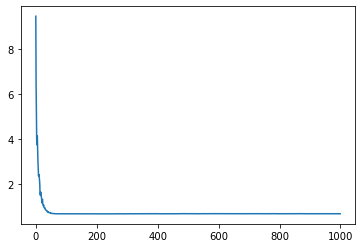

total time = 49.60256004333496
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.4484      0.4495     0.0363
pair=[4, 16]


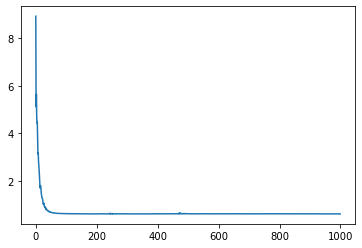

total time = 47.70024013519287
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.3598      0.3505     0.0258
pair=[5, 12]


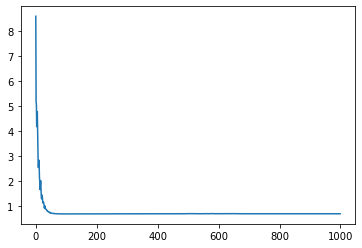

total time = 48.261865854263306
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01        0.417      0.4118        0.0
pair=[8, 10]


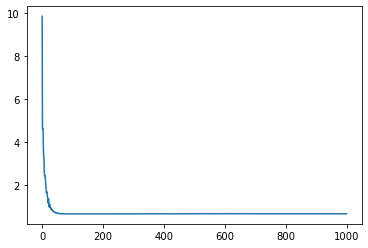

total time = 45.91936922073364
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01        0.375       0.383        0.0
endpoint_errors = 
 [0.4495, 0.3505, 0.4118, 0.383]
endpoint_stds = 
 [0.0363, 0.0258, 0.0, 0.0]
average errors: 0.3987
average stds:   0.0155


In [ ]:
endpoint_errors = []
endpoint_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = neuralNetworkClassificationCNN(data[pair[0]], data[pair[1]], Q_size = 20, 
                                       lr_decay = 0.9, learning_rate = 1e-2, 
                                       num_trials_maj = 1, out_channels = 10, kernel_size = 2,  
                                       padding = 1, bias = True, Num_updates = 1000, 
                                       D_out = 2, epoch = 50, version = 'endpoints', 
                                       sigma = 0.01, test_size = 0.3)
    print(A[0])
    endpoint_errors.append(np.round(A[1], decimals=4).tolist())
    endpoint_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('endpoint_errors = \n', endpoint_errors)
print('endpoint_stds = \n', endpoint_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(endpoint_errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(endpoint_stds), decimals=4)}', 'green'))


### Rand($v_Q$)

pair=[4, 12]


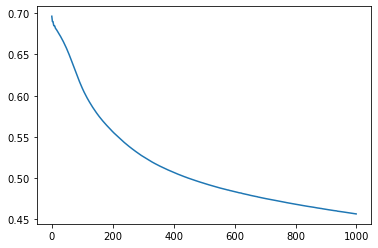

total time = 74.47297716140747
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2271      0.2649     0.0452
pair=[4, 16]


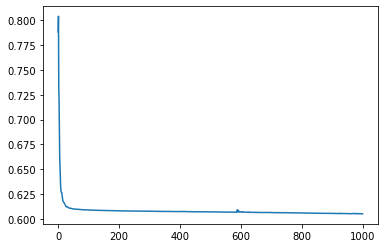

total time = 65.19497179985046
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.3547      0.3595     0.0221
pair=[5, 12]


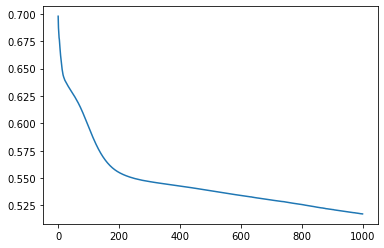

total time = 72.62026166915894
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2841      0.2998     0.0466
pair=[8, 10]


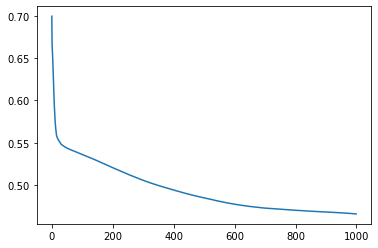

total time = 73.21078085899353
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2245       0.246     0.0324
v_Q_errors = 
 [0.2649, 0.3595, 0.2998, 0.246]
v_Q_errors_stds = 
 [0.0452, 0.0221, 0.0466, 0.0324]
average errors: 0.2926
average stds:   0.0366


In [ ]:
errors = []
errors_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = neuralNetworkClassificationCNN(data[pair[0]], data[pair[1]], Q_size = 20, 
                                       lr_decay = 0.9, learning_rate = 1e-2, 
                                       num_trials_maj=1, out_channels= 10, kernel_size= 5,
                                       padding = 1, bias = True, Num_updates = 1000, 
                                       D_out = 2, epoch = 50, version = 'unsigned', 
                                       sigma = 1, test_size = 0.3)
    print(A[0])
    errors.append(np.round(A[1], decimals=4).tolist())
    errors_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_errors = \n', errors)
print('v_Q_errors_stds = \n', errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(errors_stds), decimals=4)}', 'green'))


### Rand($v_Q^{\varsigma}$)

pair=[4, 12]


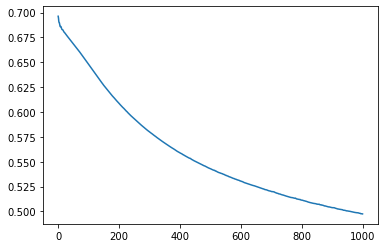

total time = 67.78945302963257
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2647      0.4256     0.0417
pair=[4, 16]


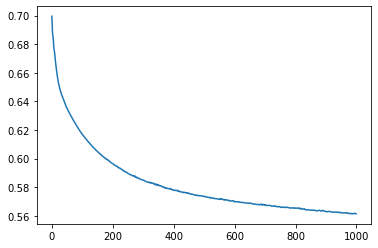

total time = 67.68787884712219
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.3124      0.3619     0.0374
pair=[5, 12]


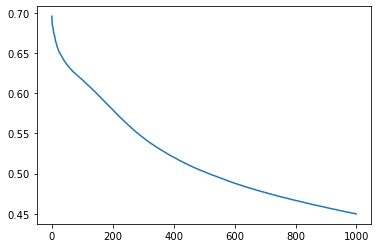

total time = 74.15168619155884
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2293       0.372     0.0511
pair=[8, 10]


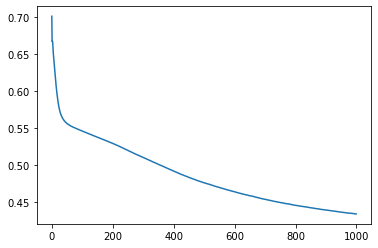

total time = 77.73493194580078
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2126      0.2962     0.0391
v_Q_varsigma_errors =  [0.4256, 0.3619, 0.372, 0.2962]
v_Q_varsigma_errors_stds =  [0.0417, 0.0374, 0.0511, 0.0391]
average errors: 0.3639
average stds:   0.0423
Total time:  289.44465017318726


In [ ]:
errors = []
errors_stds = []

s_time = time.time()
for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = neuralNetworkClassificationCNN(data[pair[0]], data[pair[1]], Q_size = 20, 
                                       lr_decay = 0.9, learning_rate = 1e-2, 
                                       num_trials_maj=1, out_channels= 10, kernel_size= 5,
                                       padding = 1, bias = True, Num_updates = 1000, 
                                       D_out = 2, epoch = 50, version = 'signed', 
                                       sigma = 1, test_size = 0.3)
    print(A[0])
    errors.append(np.round(A[1], decimals=4).tolist())
    errors_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_varsigma_errors = ', errors)
print('v_Q_varsigma_errors_stds = ', errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(errors_stds), decimals=4)}', 'green'))

print("Total time: ", time.time() - s_time)

### Rand($v_Q^{exp}$)

pair=[4, 12]


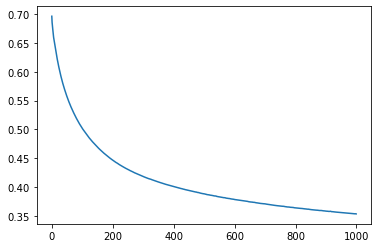

total time = 77.83004069328308
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1808      0.3157       0.05
pair=[4, 16]


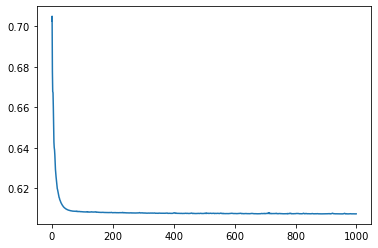

total time = 69.18580508232117
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.3543      0.3595     0.0244
pair=[5, 12]


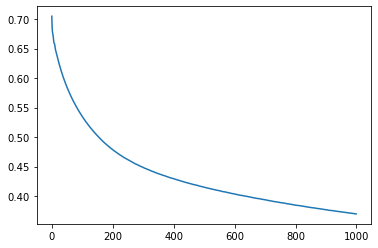

total time = 69.89727783203125
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01        0.191      0.2339      0.036
pair=[8, 10]


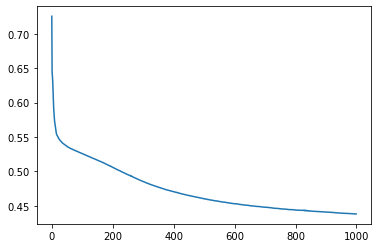

total time = 71.60671901702881
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2181       0.247      0.032
v_Q_exp_errors = 
 [0.3157, 0.3595, 0.2339, 0.247]
v_Q_exp_errors_stds = 
 [0.05, 0.0244, 0.036, 0.032]
average errors: 0.289
average stds:   0.0356


In [ ]:
errors = []
errors_stds = []

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = neuralNetworkClassificationCNN(data[pair[0]], data[pair[1]], Q_size = 20, 
                                       lr_decay = 0.9, learning_rate = 1e-2, 
                                       num_trials_maj=1, out_channels= 10, kernel_size= 5,
                                       padding = 1, bias = True, Num_updates = 1000, 
                                       D_out = 2, epoch = 50, version = 'exp', 
                                       sigma = 1, test_size = 0.3)
    print(A[0])
    errors.append(np.round(A[1], decimals=4).tolist())
    errors_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_exp_errors = \n', errors)
print('v_Q_exp_errors_stds = \n', errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(errors_stds), decimals=4)}', 'green'))


## num_maj = 11

### Vote($v_Q$)

pair=[4, 12]


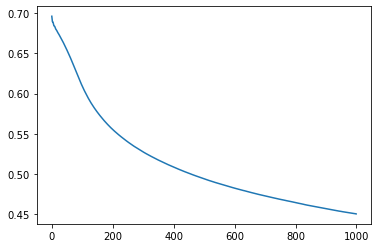

total time = 149.07518410682678
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2332      0.2542     0.0326
pair=[4, 16]


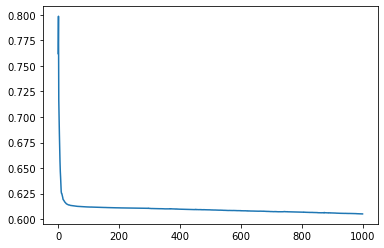

total time = 161.78457498550415
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01        0.351        0.35     0.0239
pair=[5, 12]


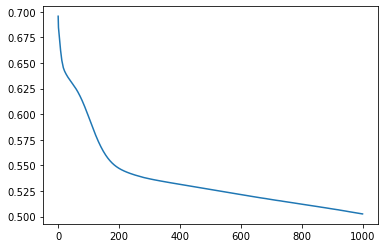

total time = 158.80015897750854
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2745      0.3216     0.0384
pair=[8, 10]


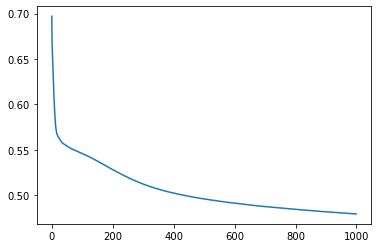

total time = 157.13693189620972
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2329      0.2255     0.0251
v_Q_errors = 
 [0.2542, 0.35, 0.3216, 0.2255]
v_Q_errors_stds = 
 [0.0326, 0.0239, 0.0384, 0.0251]
average errors: 0.2878
average stds:   0.03
Total time:  631.9235939979553


In [ ]:
errors = []
errors_stds = []
s_time = time.time()

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = neuralNetworkClassificationCNN(data[pair[0]], data[pair[1]], Q_size = 20, 
                                       lr_decay = 0.9, learning_rate = 1e-2, 
                                       num_trials_maj=11, out_channels=10, kernel_size=5,
                                       padding = 1, bias = True, Num_updates = 1000, 
                                       D_out = 2, epoch = 50, version = 'unsigned', 
                                       sigma = 1, test_size = 0.3)
    print(A[0])
    errors.append(np.round(A[1], decimals=4).tolist())
    errors_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_errors = \n', errors)
print('v_Q_errors_stds = \n', errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(errors_stds), decimals=4)}', 'green'))
print("Total time: ", time.time() - s_time)

### Vote($v_Q^{\varsigma}$)

pair=[4, 12]


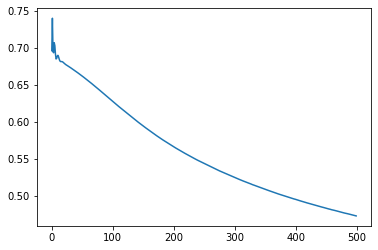

total time = 516.5109460353851
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.02       0.2429      0.4002     0.0498
pair=[4, 16]


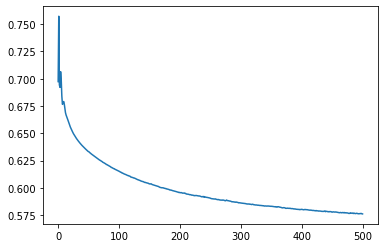

total time = 489.53240394592285
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.02       0.3307      0.3624     0.0476
pair=[5, 12]


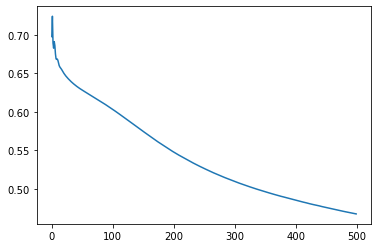

total time = 557.1358072757721
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.02       0.2503      0.3624      0.049
pair=[8, 10]


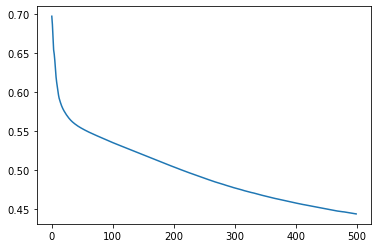

total time = 495.8857352733612
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.02       0.2089      0.2964     0.0369
v_Q_varsigma_errors = 
 [0.4002, 0.3624, 0.3624, 0.2964]
v_Q_varsigma_errors_stds = 
 [0.0498, 0.0476, 0.049, 0.0369]
average errors: 0.3554
average stds:   0.0458
Total time:  2071.6065859794617


In [ ]:
errors = []
errors_stds = []
s_time = time.time()

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = neuralNetworkClassificationCNN(data[pair[0]], data[pair[1]], Q_size = 20, 
                                       lr_decay = 0.9, learning_rate = 2e-2, 
                                       num_trials_maj=11, out_channels=10, kernel_size=5,
                                       padding = 1, bias = True, Num_updates = 500, 
                                       D_out = 2, epoch = 50, version = 'signed', 
                                       sigma = 1, test_size = 0.3)
    print(A[0])
    errors.append(np.round(A[1], decimals=4).tolist())
    errors_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_varsigma_errors = \n', errors)
print('v_Q_varsigma_errors_stds = \n', errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(errors_stds), decimals=4)}', 'green'))
print("Total time: ", time.time() - s_time)

### Vote($v_Q^{exp}$)

pair=[4, 12]


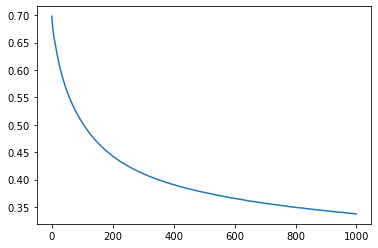

total time = 169.57141590118408
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1713      0.2907     0.0365
pair=[4, 16]


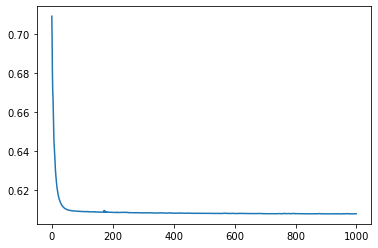

total time = 144.0591402053833
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.3547      0.3571     0.0151
pair=[5, 12]


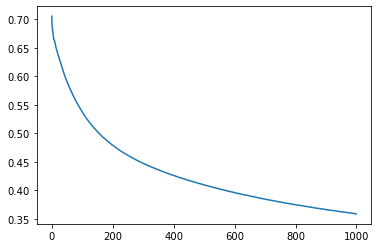

total time = 163.39673495292664
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1932       0.248     0.0364
pair=[8, 10]


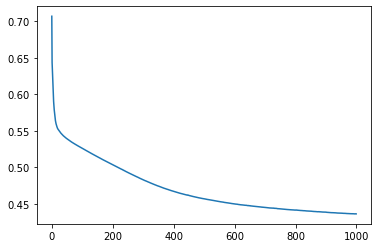

total time = 142.6762797832489
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2194      0.2489     0.0286
v_Q_exp_errors = 
 [0.2907, 0.3571, 0.248, 0.2489]
v_Q_exp_errors_stds = 
 [0.0365, 0.0151, 0.0364, 0.0286]
average errors: 0.2862
average stds:   0.0292
Total time:  625.3520429134369


In [ ]:
errors = []
errors_stds = []
s_time = time.time()

for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = neuralNetworkClassificationCNN(data[pair[0]], data[pair[1]], Q_size = 20, 
                                       lr_decay = 0.9, learning_rate = 1e-2, 
                                       num_trials_maj=11, out_channels=10, kernel_size=5,
                                       padding = 1, bias = True, Num_updates = 1000, 
                                       D_out = 2, epoch = 50, version = 'exp', 
                                       sigma = 1, test_size = 0.3)
    print(A[0])
    errors.append(np.round(A[1], decimals=4).tolist())
    errors_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_exp_errors = \n', errors)
print('v_Q_exp_errors_stds = \n', errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(errors_stds), decimals=4)}', 'green'))
print("Total time: ", time.time() - s_time)

# Neural Network for Mistake Driven Method of Choosing $Q$

## Initialize $Q$

In [ ]:
def initialize_Q(train_1, train_2, std_coeff, out_channels, kernel_size, Q_size, 
                 padding, learning_rate = 1e-3, bias = True, D_out=2, lr_decay = 0.9, 
                 Num_updates = 100): 
        
    Q = []
    errors = []
    losses = np.zeros((Q_size - kernel_size, Num_updates))
    
    mu = get_mu(train_1, train_2)
    std = mu * std_coeff

    trajectory_train_data = np.concatenate((train_1, train_2), axis = 0)
    train_labels = np.concatenate(([1] * len(train_1), [0] * len(train_2)), 0)
    train_labels = torch.from_numpy(train_labels).long()
    index = np.random.randint(0, high=len(trajectory_train_data)) 
    k = np.random.randint(0, high=len(trajectory_train_data[index]))
    for i in range(kernel_size):
        q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
        Q.append(q)

    for i in range(Q_size - kernel_size):
        train_data = ExpCurve2Vec(np.array(Q), trajectory_train_data, mu)
        model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                            out_channels = out_channels, 
                            kernel_size = kernel_size,
                            stride  = 1,
                            padding = padding,
                            bias = bias),
                nn.ReLU(),
                #nn.LeakyReLU(0.01),
                #nn.Tanh(),
                Flatten(),
                nn.Linear(out_channels * (len(train_data[0]) - kernel_size + 1 + 2 * padding), 
                            D_out)
                )
    
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        
        train_data = torch.from_numpy(train_data).float()
        train_data = train_data.view(len(train_data), 1, len(train_data[0]))
        
        for k in range(Num_updates):
            x_pred = model(train_data) # of shape (N, D_out)
            loss = loss_fn(x_pred, train_labels)
            losses[i, k] = loss
            
            if (k+1) % 100 == 0:
                optimizer.param_groups[0]['lr'] = lr_decay * learning_rate
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 
        
        train_pred = torch.argmax(model(train_data), axis=1)
        scores = model(train_data)
        I = np.where((train_labels == train_pred) == False)[0]

        temp_labels = 2 * train_labels.numpy().reshape(len(train_labels.numpy()), 1) - 1
        temp = temp_labels * scores.detach().numpy()
        temp = np.max(temp, axis=1)
        index = I[np.argmax(temp[I])]

        error = sum(train_labels != train_pred)/len(train_labels)
        errors.append(error.item())
        
        k = np.random.randint(0, high=len(trajectory_train_data[index]))
        q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
        Q.append(q)

    final_error = errors[-1]

    #plt.plot((np.mean(losses, axis=0)))
    #plt.show()

    return np.array(Q), np.array(errors), mu, final_error


In [ ]:
def MD_NeuralNetworkClassificationCNN(data_1, data_2, maj_num, epoch, init_iter, 
                                      test_size, std_coeff, out_channels, kernel_size, 
                                      Q_size, padding, learning_rate = 1e-3, 
                                      bias = True, D_out=2, lr_decay = 0.9, 
                                      Num_updates = 100):
        
    start_time = time.time()

    train_errors = np.zeros(epoch) 
    test_errors = np.zeros(epoch)

    n_1 = len(data_1)
    n_2 = len(data_2) 

    for s in range(epoch):
        train_idx_1, test_idx_1, train_label_1, test_label_1, train_idx_2, \
        test_idx_2, train_label_2, test_label_2 = train_test(data_1, data_2, test_size)

        train = np.concatenate((data_1[train_idx_1], data_2[train_idx_2]), 0)
        test = np.concatenate((data_1[test_idx_1], data_2[test_idx_2]), 0)
        train_labels = np.concatenate((train_label_1, train_label_2), axis = 0)
        test_labels = np.concatenate((test_label_1, test_label_2), axis = 0)
        train_labels = torch.from_numpy(train_labels).long()
        test_labels = torch.from_numpy(test_labels).long()

        x_preds = torch.zeros((maj_num, len(train)))
        y_preds = torch.zeros((maj_num, len(test)))
        
        I = np.arange(len(train))
        np.random.shuffle(I)
        train = train[I]
        train_labels = train_labels[I]
        
        J = np.arange(len(test))
        np.random.shuffle(J)
        test = test[J]
        test_labels = test_labels[J]

        for t in range(maj_num):

            Q_list = []
            temp_errors = []
            mu_temp = []

            for j in range(init_iter):
                B = initialize_Q(data_1[train_idx_1], data_2[train_idx_2], 
                                 std_coeff, out_channels, kernel_size, Q_size, 
                                 padding, learning_rate = 1e-3, bias = True, 
                                 D_out=2, lr_decay = 0.9, Num_updates = 100)

                Q_list.append(B[0])
                mu_temp.append(B[2])
                temp_errors.append(B[-1])

            h = np.argmin(temp_errors)
            Q = Q_list[h]
            mu = mu_temp[h]

            train_data = torch.from_numpy(ExpCurve2Vec(Q, train, mu)).float()
            train_data = train_data.view(len(train_data), 1, len(train_data[0]))

            test_data = torch.from_numpy(ExpCurve2Vec(Q, test, mu)).float()
            test_data = test_data.view(len(test_data), 1, len(test_data[0]))

            model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                    nn.ReLU(),
                    #nn.LeakyReLU(0.01),
                    #nn.Tanh(),
                    Flatten(),
                    nn.Linear(out_channels * (len(train_data[0][0]) - kernel_size + 1 + 2 * padding), 
                              D_out)
                    )
        
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        
            for k in range(Num_updates):
                x_pred = model(train_data) # of shape (N, D_out)
                loss = loss_fn(x_pred, train_labels)

                if (k+1) % 10 == 0:
                    optimizer.param_groups[0]['lr'] = lr_decay * learning_rate
                optimizer.zero_grad()
                loss.backward() 
                optimizer.step() 

            scores = model(train_data)
            
            x_preds[t] = torch.argmax(scores, axis=1)
            y_preds[t] = torch.argmax(model(test_data), axis=1)

        x_preds = torch.tensor(find_majority_array(x_preds))
        y_preds = torch.tensor(find_majority_array(y_preds))

        train_errors[s] = sum(abs(train_labels - x_preds))/len(train_labels)
        test_errors[s] = sum(abs(test_labels - y_preds))/len(test_labels)

    train_error_mean = np.mean(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    Dict = {"CNN 1-Layer": [out_channels, learning_rate, 
                            np.round(train_error_mean, decimals = 4), 
                            np.round(test_error_mean, decimals = 4),
                            np.round(test_error_std, decimals = 4)]}

    pdf = pd.DataFrame.from_dict(Dict, orient='index', 
                                 columns=['Channel 1', 'Learning Rate', 
                                          'Train Error', 'Test Error', 'Std Error'])

    print(colored(f"total time = {time.time() - start_time}", "red"))
    print("mu =", mu)

    return pdf, test_error_mean, test_error_std


### num_maj = 1

In [ ]:
errors = []
errors_stds = []

s_time = time.time()
for pair in pairs_final:
    print(colored(f"pair={pair}", 'green'))
    A = MD_NeuralNetworkClassificationCNN(data[pair[0]], data[pair[1]], maj_num=1, 
                                          epoch=50, init_iter=3, 
                                          test_size=0.3, std_coeff=1, out_channels=10, 
                                          kernel_size = 5, Q_size = 20, padding = 1, 
                                          learning_rate = 1e-2, bias = True, D_out=2, 
                                          lr_decay = 0.9, Num_updates = 1000)
    print(A[0])
    errors.append(np.round(A[1], decimals=4).tolist())
    errors_stds.append(np.round(A[2], decimals=4).tolist())
    print("===========================================================================")

print('errors = ', errors)
print('errors_stds = ', errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(errors_stds), decimals=4)}', 'green'))

print("Total time: ", time.time() - s_time)

pair=[4, 12]
total time = 437.2454528808594
mu = 0.008984696989543295
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1802      0.3092     0.0602
pair=[4, 16]
total time = 376.48109912872314
mu = 2.634461987923416
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2581      0.2824     0.0445
pair=[5, 12]
total time = 411.6979649066925
mu = 0.03163125449859194
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1372      0.2055     0.0384
pair=[8, 10]
total time = 402.5970878601074
mu = 0.12528473032121212
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1943      0.2281     0.0366
errors =  [0.3092, 0.2824, 0.2055, 0.2281]
errors_stds =  [0.0602, 0.0445, 0.0384, 0.0366]
average errors: 0.2563
average stds:   0.

### num_maj = 11

In [ ]:
MD_errors = []
MD_errors_stds = []

In [ ]:
s_time = time.time()
pair = pairs_final[0]
print(colored(f"pair={pair}", 'green'))
A = MD_NeuralNetworkClassificationCNN(data[pair[0]], data[pair[1]], maj_num=11, epoch=50, 
                                      init_iter=3, test_size=0.3, std_coeff=1, 
                                      out_channels=10, kernel_size = 5, Q_size = 20, 
                                      padding = 1, learning_rate = 1e-2, bias = True, 
                                      D_out=2, lr_decay = 0.9, Num_updates = 1000)
print(A[0])
MD_errors.append(np.round(A[1], decimals=4).tolist())
MD_errors_stds.append(np.round(A[2], decimals=4).tolist())
print("time: ", time.time() - s_time)

pair=[4, 12]
total time = 5078.238649845123
mu = 0.005970617873011008
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.1845       0.317     0.0649
time:  5078.24958896637


In [ ]:
s_time = time.time()
pair = pairs_final[1]
print(colored(f"pair={pair}", 'green'))
A = MD_NeuralNetworkClassificationCNN(data[pair[0]], data[pair[1]], maj_num=11, epoch=50, 
                                      init_iter=3, test_size=0.3, std_coeff=1, 
                                      out_channels=10, kernel_size = 5, Q_size = 20, 
                                      padding = 1, learning_rate = 1e-2, bias = True, 
                                      D_out=2, lr_decay = 0.9, Num_updates = 1000)
print(A[0])
MD_errors.append(np.round(A[1], decimals=4).tolist())
MD_errors_stds.append(np.round(A[2], decimals=4).tolist())
print("time: ", time.time() - s_time)

pair=[4, 16]
total time = 4203.108588933945
mu = 2.439590564291869
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2718      0.2895     0.0473
time:  4203.115154743195


In [ ]:
s_time = time.time()
pair = pairs_final[2]
print(colored(f"pair={pair}", 'green'))
A = MD_NeuralNetworkClassificationCNN(data[pair[0]], data[pair[1]], maj_num=11, epoch=50, 
                                      init_iter=3, test_size=0.3, std_coeff=1, 
                                      out_channels=10, kernel_size = 5, Q_size = 20, 
                                      padding = 1, learning_rate = 1e-2, bias = True, 
                                      D_out=2, lr_decay = 0.9, Num_updates = 1000)
print(A[0])
MD_errors.append(np.round(A[1], decimals=4).tolist())
MD_errors_stds.append(np.round(A[2], decimals=4).tolist())
print("time: ", time.time() - s_time)

pair=[5, 12]
total time = 4563.609216928482
mu = 0.04107004167798323
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.2135       0.239     0.0438
time:  4563.617468118668


In [ ]:
s_time = time.time()
pair = pairs_final[3]
print(colored(f"pair={pair}", 'green'))
A = MD_NeuralNetworkClassificationCNN(data[pair[0]], data[pair[1]], maj_num=11, epoch=50, 
                                      init_iter=3, test_size=0.3, std_coeff=1, 
                                      out_channels=10, kernel_size = 5, Q_size = 20, 
                                      padding = 1, learning_rate = 1e-2, bias = True, 
                                      D_out=2, lr_decay = 0.9, Num_updates = 1000)
print(A[0])
MD_errors.append(np.round(A[1], decimals=4).tolist())
MD_errors_stds.append(np.round(A[2], decimals=4).tolist())
print("time: ", time.time() - s_time)

pair=[8, 10]
total time = 3948.12655210495
mu = 0.11464535602645753
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01        0.219       0.224       0.03
time:  3948.129896879196


In [ ]:
print('errors = ', MD_errors)
print('errors_stds = ', MD_errors_stds)
print("===========================================================================")
print(colored(f'average errors: {np.round(np.mean(MD_errors), decimals=4)}', 'blue'))
print(colored(f'average stds:   {np.round(np.mean(MD_errors_stds), decimals=4)}', 'green'))


errors =  [0.317, 0.2895, 0.239, 0.224]
errors_stds =  [0.0649, 0.0473, 0.0438, 0.03]
average errors: 0.2674
average stds:   0.0465


# Plot test errors

In [ ]:
def lower_limit_error(x, y):
    if y - x < 0:
        return y
    else:
        return x

lower_limit_error = np.vectorize(lower_limit_error)

In [ ]:
A_LSVM = [0.2740, 0.3269, 0.4772, 0.3214, 0.2888, 0.3258, 0.4860, 0.3339, 0.4326]
A_GSVM = [0.2090, 0.2788, 0.3414, 0.2854, 0.2447, 0.2744, 0.3496, 0.2886, 0.2810]
A_PSVM = [0.2518, 0.3302, 0.3822, 0.3196, 0.2567, 0.3278, 0.3829, 0.3226, 0.3311]
A_DT = [0.1836, 0.2221, 0.2955, 0.2386, 0.2132, 0.2492, 0.3244, 0.2631, 0.2136]
A_RF = [0.1652, 0.2172, 0.2812, 0.2293, 0.1731, 0.2213, 0.2875, 0.2320, 0.1723]
A_KNN = [0.1931, 0.2303, 0.3201, 0.2298, 0.2067, 0.2306, 0.3406, 0.2388, 0.2156]
A_LR = [0.2954, 0.3496, 0.4175, 0.3293, 0.3022, 0.3469, 0.4168, 0.3318, 0.3461]
A_CNN = [0.2674, 0.2878, 0.3554, 0.2862, 0.2563, 0.2926, 0.3639, 0.2890, 0.3987]

A = np.array([A_LSVM, A_GSVM, A_PSVM, A_DT, A_RF, A_KNN, A_LR, A_CNN])
B = A.T

In [ ]:
std_LSVM = [0.0497, 0.0412, 0.0460, 0.0410, 0.0448, 0.0417, 0.0476, 0.0469, 0.0368]
std_GSVM = [0.0373, 0.0356, 0.0320, 0.0339, 0.0364, 0.0338, 0.0355, 0.0350, 0.0300]
std_PSVM = [0.0356, 0.0283, 0.0174, 0.0300, 0.0397, 0.0324, 0.0184, 0.0326, 0.0226]
std_DT = [0.0339, 0.0381, 0.0399, 0.0404, 0.0390, 0.0423, 0.0452, 0.0454, 0.0428]
std_RF = [0.0334, 0.0374, 0.0363, 0.0356, 0.0338, 0.0402, 0.0412, 0.0401, 0.0341]
std_KNN = [0.0354, 0.0395, 0.0374, 0.0360, 0.0395, 0.0370, 0.0431, 0.0400, 0.0384]
std_LR = [0.0383, 0.0219, 0.0121, 0.0347, 0.0359, 0.0238, 0.0121, 0.0331, 0.0170]
std_CNN = [0.0465, 0.0300, 0.0458, 0.0292, 0.0449, 0.0366, 0.0423, 0.0356, 0.0155]

C = np.array([std_LSVM, std_GSVM, std_PSVM, std_DT, std_RF, std_KNN, std_LR, std_CNN]).T

In [ ]:
# for KNN
errors = [0.2349, 0.2111, 0.1985, 0.1921, 0.1946, 0.1940, 0.2138, 0.1717, 0.3315, 
          0.4413, 0.3649, 0.2051]

stds = [0.0372, 0.0375, 0.0377, 0.0357, 0.0368, 0.0346, 0.0468, 0.0383, 0.0464,
        0.0422, 0.0869, 0.0352]

In [ ]:
classifiers = ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR', 'CNN']

FM = (r'KNN', r'Vote(MD $v_Q^{exp}$)', r'Vote(Rand $v_Q$)', r'Vote($v_Q^{\varsigma}$)', 
      r'Vote(Rand $v_Q^{exp}$)', r'MD $v_Q^{exp}$', r'Rand $v_Q$', 
      r'Rand $v_Q^{\varsigma}$', r'Rand $v_Q^{exp}$', 'Endpoints')

labels = ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR', 'CNN']

dists = [r'$d_F$', r'$d_{dF}$', r'$dH$', r'DTW', r'soft-dtw', r'fastdtw', 
         r'LCSS', r'SSPD', r'EDR', r'ERP', r'LSH', r'$d_Q^{\pi}$']

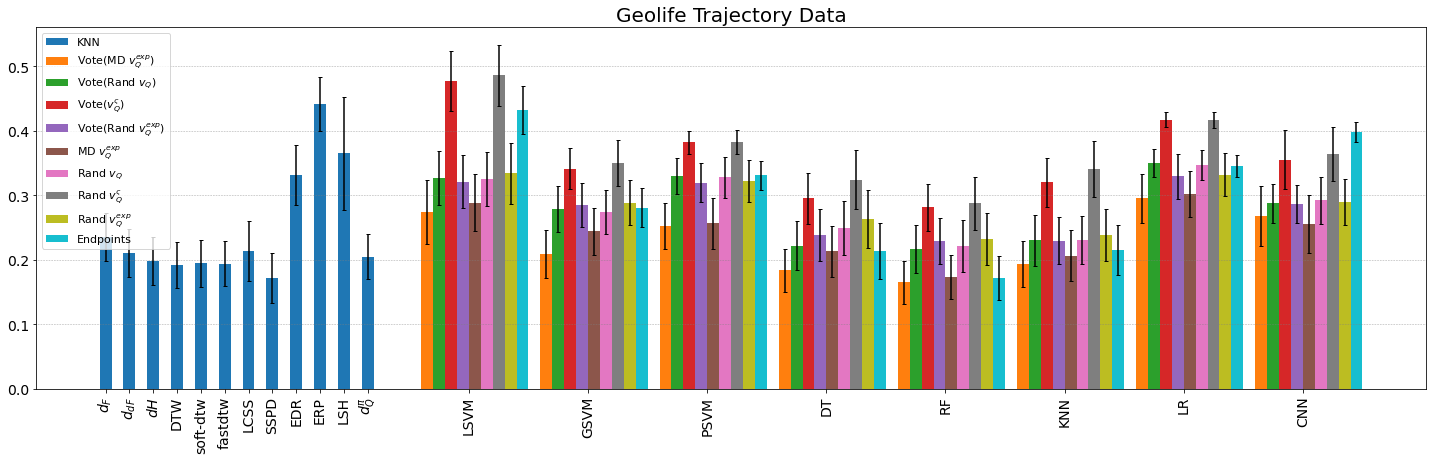

In [ ]:
width=0.1
index = np.arange(len(stds))
ind = np.arange(len(A)) + len(index) * 0.25

plt.subplots(figsize = (20, 6.5), tight_layout=True)
bars = [0] * 10

lower_lim = lower_limit_error(stds, errors)
bars[0] = plt.bar(index * 0.2, errors, width, yerr=[lower_lim, stds], capsize=2)

for i in range(len(FM)-1):
    lower_limit = lower_limit_error(C[i], B[i])
    bars[i+1] = plt.bar(ind+width*i-0.3, B[i], width, yerr=[lower_limit, C[i]], capsize=2)

plt.title('Geolife Trajectory Data', fontsize = 20)
plt.xticks(list(np.arange(len(stds)) * 0.2) + list(ind + 0.5 * width), 
           dists + labels, fontsize = 14)

plt.legend(tuple(bars), FM, loc=0, fontsize = 11)

plt.gca().yaxis.grid(color='gray', linestyle='dotted', linewidth=0.6)
plt.xticks(rotation='vertical', fontsize = 14)
plt.yticks(fontsize = 14)

plt.savefig('/Users/hasan/Desktop/plots/plots Geolife/Geolife bar chart all horizontal.png', 
            bbox_inches='tight', dpi=200)

plt.show()
